In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
from utils.predictiveNet import PredictiveNet
import matplotlib.pyplot as plt
import numpy as np
from utils.general import saveFig
import itertools
import torch
import random
from utils.agent import RandomActionAgent
from analysis.representationalGeometryAnalysis import representationalGeometryAnalysis

In [4]:
savefolder = 'Figures/S10_Hyperparm/'

In [5]:
nettypes = ['thRNN_5win']
kvalues = ['2']
hpidx = ['0','1','2','3','4','5','6','7','8','9','10',
         '11','12','13','14','15','16','17','18','19',
        '20','21','22','23','24']
#seeds = ['40','41','42','43','44','45','46','47','48','49']
#seeds = ['30','31','32','33','34','35','36','37','38','39']
seeds = ['0','1','2','3','4','5','6','7','8','9']
#lr = [1e-4,1.5e-4,3e-4,5.5e-4,1e-3,1.5e-3,3e-3]
netprops = itertools.product(*[nettypes,['-'],hpidx,['-s'],seeds])
netprops = list(netprops)
netnames = [''.join(name) for name in netprops]
nettype = [name[0] for name in netprops]
#netmask = [name[4] for name in netprops]
netk = [int(name[2]) for name in netprops]

netfolder = '/hyperparm_panel_masked/'

analysisFrame_mask = pd.DataFrame(data={'filename':netnames, 'type':nettype, 'netfolder':netfolder})

In [6]:
nettypes = ['AutoencoderPred_LN']
kvalues = ['2']
hpidx = ['0','1','2','3','4','5','6','7','8','9','10',
         '11','12','13','14','15','16','17','18','19',
        '20','21','22','23','24']
#seeds = ['30','31','32','33','34','35','36','37','38','39']
#lr = [1e-4,1.5e-4,3e-4,5.5e-4,1e-3,1.5e-3,3e-3]

netprops = itertools.product(*[nettypes,['-'],hpidx,['-s'],seeds])
netprops = list(netprops)
netnames = [''.join(name) for name in netprops]
nettype = [name[0] for name in netprops]
#netmask = [name[4] for name in netprops]
netk = [int(name[2]) for name in netprops]

netfolder = '/hyperparm_panel_sparse/'

analysisFrame_NS = pd.DataFrame(data={'filename':netnames, 'type':nettype, 'netfolder':netfolder})

In [7]:
#netfolder = '/hyperparm_panel_masked/'
def loadNet(row):
    netfolder = row.netfolder
    try:
        net = PredictiveNet.loadNet(netfolder+row['filename'],suppressText=True)
        return net
    except:
        print(f"{row['filename']} does not exist")
        #net = PredictiveNet
        

#analysisFrame_mask['net'] = analysisFrame_mask.apply(loadNet, axis = 1)
#analysisFrame_NS['net'] = analysisFrame_NS.apply(loadNet, axis = 1)

In [8]:
#analysisFrame['net'][0].trainArgs
def getTrainParms(row):
    #predictiveNet = row['net']
    predictiveNet = loadNet(row)
    lr = predictiveNet.trainArgs.lr
    seed = predictiveNet.trainArgs.seed
    weight_decay = predictiveNet.trainArgs.weight_decay
    bptttrunc = predictiveNet.trainArgs.bptttrunc
    seqdur = predictiveNet.trainArgs.seqdur
    dropp = predictiveNet.trainArgs.dropout
    ntimescale = predictiveNet.trainArgs.ntimescale
    nneurons = predictiveNet.trainArgs.hiddensize
    noisestd = predictiveNet.trainArgs.noisestd
    sparsity = predictiveNet.trainArgs.sparsity
    bias_lr = predictiveNet.trainArgs.bias_lr
    
    return lr,bptttrunc,seqdur,seed,dropp,ntimescale,weight_decay,nneurons,noisestd,sparsity,bias_lr
analysisFrame_mask[['lr','bptt','seqdur','seed','dropp','ntimescale','weight_decay',
                    'nneurons','noisestd','sparsity','bias_lr']] = analysisFrame_mask.apply(getTrainParms, axis = 1, result_type="expand")

analysisFrame_NS[['lr','bptt','seqdur','seed','dropp','ntimescale','weight_decay',
                  'nneurons','noisestd','sparsity','bias_lr']] = analysisFrame_NS.apply(getTrainParms, axis = 1, result_type="expand")

In [9]:
def getPredPerformance(row):
    #predictiveNet = row['net']
    predictiveNet = loadNet(row)
    try:
        finalLoss = predictiveNet.TrainingSaver['loss'].values[-1]
    except:
        try:
            finalLoss = predictiveNet.TrainingSaver['loss']
        except:
            finalLoss = predictiveNet.TrainingSaver.transpose()['loss']
        
    
    return finalLoss 

analysisFrame_NS['finalLoss'] = analysisFrame_NS.apply(getPredPerformance, axis = 1)
analysisFrame_mask['finalLoss'] = analysisFrame_mask.apply(getPredPerformance, axis = 1)

In [10]:
#Calculate spatial info and decoding performance
def getSpatialRep(row):
    predictiveNet = loadNet(row)
    #print(len(predictiveNet.TrainingSaver['sRSA'].values))
    numepochs = len(predictiveNet.TrainingSaver['sRSA'].values)
    try:
        SI = predictiveNet.TrainingSaver['SI'].values[-1]
        sRSA = predictiveNet.TrainingSaver['sRSA'].values[-1]

        EVs = predictiveNet.TrainingSaver['EVs'].values[-1]
        
        SWdist = predictiveNet.TrainingSaver['SWdist'].values[-1]
        finalLoss = predictiveNet.TrainingSaver['loss'].values[-1]
    except:
        try:
            SI = predictiveNet.TrainingSaver['SI']
            sRSA = predictiveNet.TrainingSaver['sRSA']

            EVs = predictiveNet.TrainingSaver['EVs']

            SWdist = predictiveNet.TrainingSaver['SWdist']
            finalLoss = predictiveNet.TrainingSaver['loss']
        except:
            SI = predictiveNet.TrainingSaver.transpose()['SI'].values[-1]
            sRSA = predictiveNet.TrainingSaver.transpose()['sRSA'].values[-1]

            EVs = predictiveNet.TrainingSaver.transpose()['EVs'].values[-1]

            SWdist = predictiveNet.TrainingSaver.transpose()['SWdist'].values[-1]
            finalLoss = predictiveNet.TrainingSaver.transpose()['loss'].values[-1]
    
    alphaN = predictiveNet.TrainingSaver['replay_alpha_noise'].values[-1]
    alphaQ = predictiveNet.TrainingSaver['replay_alpha_query'].values[-1]
    alphaA = predictiveNet.TrainingSaver['replay_alpha_adapt'].values[-1]

    intN = predictiveNet.TrainingSaver['replay_int_noise'].values[-1]
    intQ = predictiveNet.TrainingSaver['replay_int_query'].values[-1]
    intA = predictiveNet.TrainingSaver['replay_int_adapt'].values[-1]
    
    viewN = predictiveNet.TrainingSaver['replay_view_noise'].values[-1]
    viewQ = predictiveNet.TrainingSaver['replay_view_query'].values[-1]
    viewA = predictiveNet.TrainingSaver['replay_view_adapt'].values[-1]
    
    cohereN = predictiveNet.TrainingSaver['replay_coherence_noise'].values[-1]
    cohereQ = predictiveNet.TrainingSaver['replay_coherence_query'].values[-1]
    cohereA = predictiveNet.TrainingSaver['replay_coherence_adapt'].values[-1]
    
    extentN = predictiveNet.TrainingSaver['replay_extent_noise'].values[-1]
    extentQ = predictiveNet.TrainingSaver['replay_extent_query'].values[-1]
    extentA = predictiveNet.TrainingSaver['replay_extent_adapt'].values[-1]
    
    meanSI = np.nanmean(SI)
    EVsp50 = np.nanmean(EVs>0.5)
    tunedSI = np.nanmean(SI[EVs>0.5])
    
    return (SI, meanSI, sRSA, EVs, EVsp50, finalLoss, SWdist, tunedSI, numepochs,
            alphaN, alphaQ, alphaA, 
            intN, intQ, intA,
            viewN, viewQ, viewA,
            cohereN, cohereQ, cohereA,
            extentN, extentQ, extentA)
            
analysisFrame_NS[['SI','meanSI','sRSA','EVs','EVs50','finalLoss','SWdist','tunedSI','numepochs',
                 'alphaN', 'alphaQ', 'alphaA', 'intN', 'intQ', 'intA',
                 'viewN', 'viewQ', 'viewA', 'cohereN', 'cohereQ', 'cohereA',
            'extentN', 'extentQ', 'extentA']] = analysisFrame_NS.apply(getSpatialRep, axis = 1, result_type="expand")
analysisFrame_mask[['SI','meanSI','sRSA','EVs','EVs50','finalLoss','SWdist','tunedSI','numepochs',
                 'alphaN', 'alphaQ', 'alphaA', 'intN', 'intQ', 'intA',
                 'viewN', 'viewQ', 'viewA', 'cohereN', 'cohereQ', 'cohereA',
            'extentN', 'extentQ', 'extentA']] = analysisFrame_mask.apply(getSpatialRep, axis = 1, result_type="expand")


/tmp/ipykernel_2157518/3389938177.py:54: RuntimeWarning: Mean of empty slice
  tunedSI = np.nanmean(SI[EVs>0.5])


In [11]:
#Load Example Network
#Example Net
netname = 'thRNN_5win'
exseed = 102
netfolder = '/maskedk_panel/'
exampleNet = pd.DataFrame(index=[0], data={'filename':netname+'-SpeedHD-s'+str(exseed), 'type':netname, 'netfolder':netfolder})
#exampleNet['net'] = PredictiveNet.loadNet(netfolder+netname+'-Onehot-s'+str(exseed))
#exampleNet[['lr','bptt','seqdur','seed']] = exampleNet.apply(getTrainParms, axis = 1, result_type="expand")
exampleNet['finalLoss'] = exampleNet.apply(getPredPerformance, axis = 1)
exampleNet[['SI','meanSI','sRSA','EVs','EVs50','finalLoss','SWdist','tunedSI','numepochs',
                 'alphaN', 'alphaQ', 'alphaA', 'intN', 'intQ', 'intA',
                 'viewN', 'viewQ', 'viewA', 'cohereN', 'cohereQ', 'cohereA',
            'extentN', 'extentQ', 'extentA']] = exampleNet.apply(getSpatialRep, axis = 1, result_type="expand")

exampleNet[['lr','bptt','seqdur','seed','dropp','ntimescale','weight_decay',
                  'nneurons','noisestd','sparsity','bias_lr']] = exampleNet.apply(getTrainParms, axis = 1, result_type="expand")


In [15]:
analysisFrame = analysisFrame_mask
netkind = "k5"

for frame in [analysisFrame,exampleNet]:
    frame['effectiveBptt'] = frame[['bptt','seqdur']].min(axis=1)
    frame['rec_weight_decay'] = frame['weight_decay']*frame['lr']
    frame['abs_rec_lr'] = frame['lr']*np.sqrt(1/frame['nneurons'])
    frame['abs_bias_lr'] =  frame['bias_lr']*frame['lr']
    frame['wrec_bias_lr'] =  frame['abs_bias_lr']/frame['abs_rec_lr']
    frame['10dropp']=10**frame['dropp']
    frame['10ntimescale']=10**frame['ntimescale']  
    frame['10sparsity']=10**frame['sparsity']  
                                        

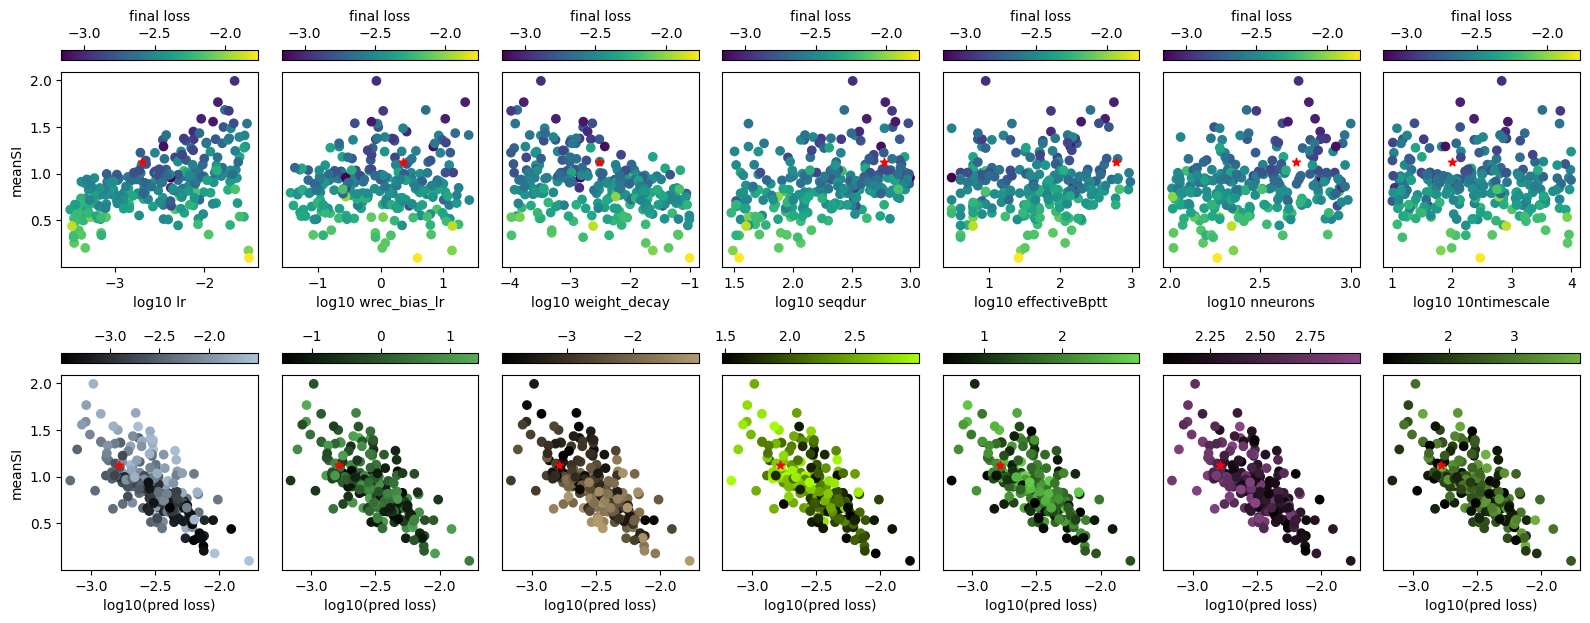

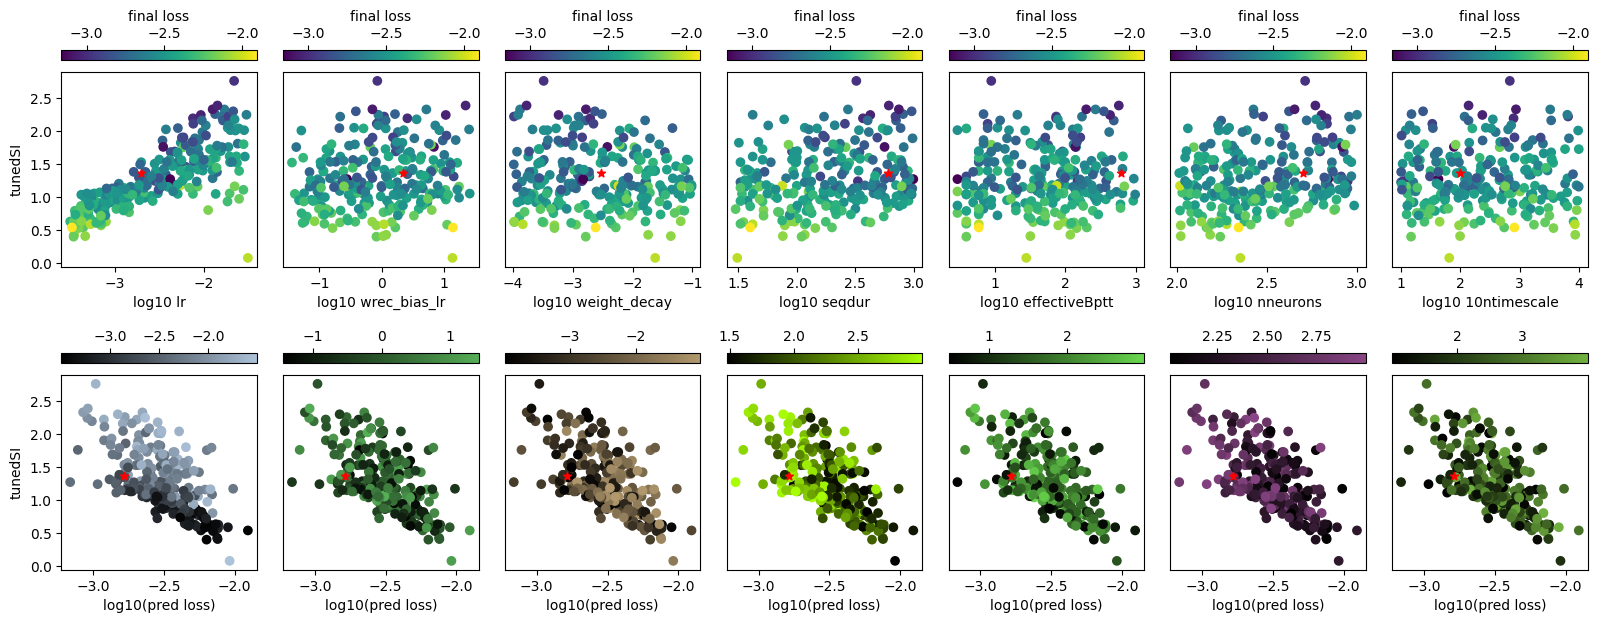

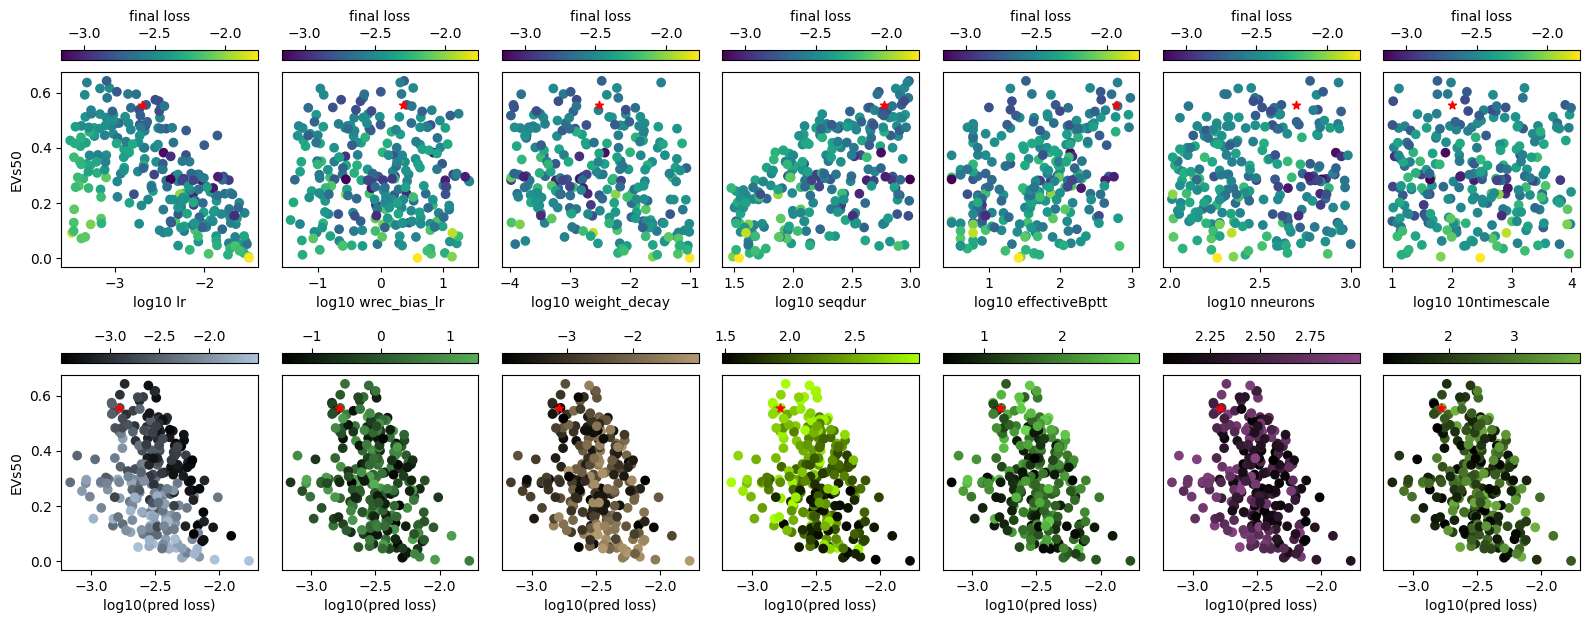

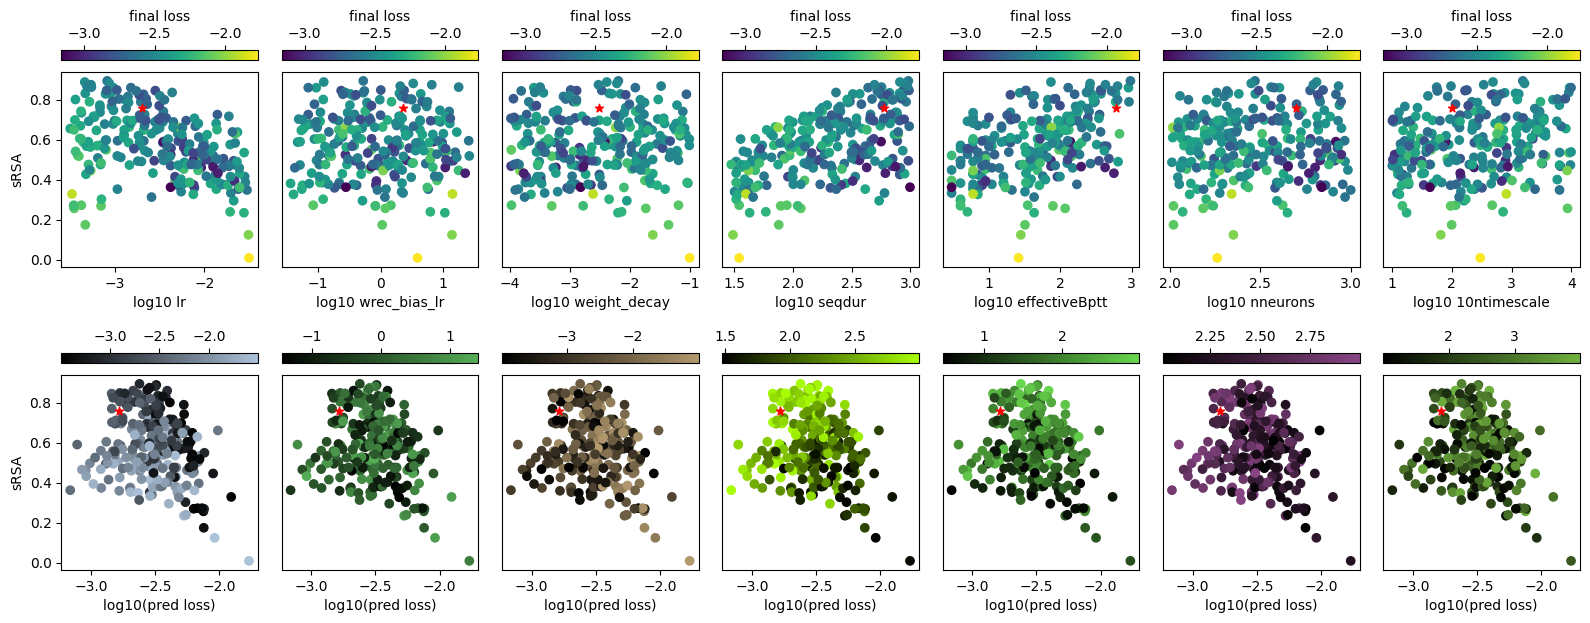

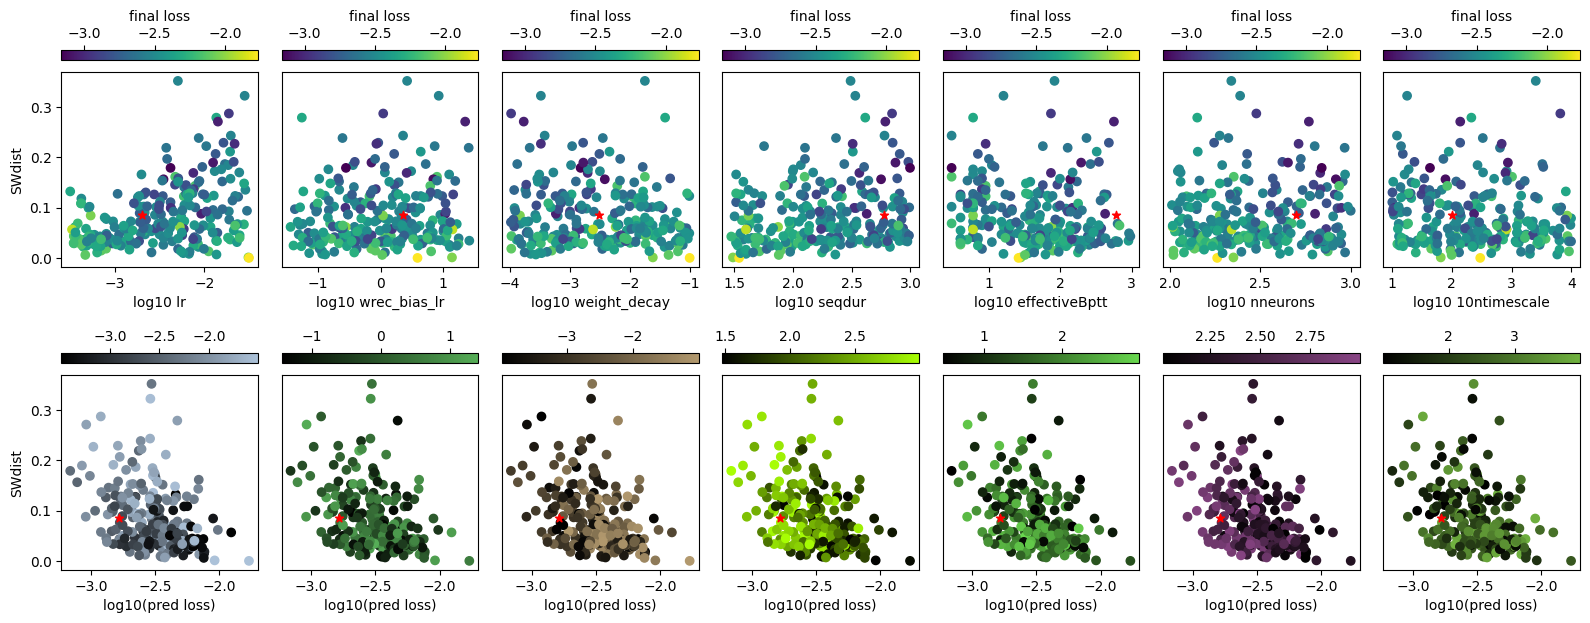

In [16]:
analysisFrame = analysisFrame_mask
withExample = True
hparms = ['lr','wrec_bias_lr','weight_decay','seqdur','effectiveBptt','nneurons','10ntimescale' ]
metrics = ['meanSI','tunedSI','EVs50','sRSA','SWdist']

numh = len(hparms)

import matplotlib as mplt
colors = list(mplt.colors.XKCD_COLORS) 


#usenets = (analysisFrame['nneurons']>30) & (analysisFrame['rel_weight_decay']<1e-2)
usenets = (analysisFrame['nneurons']>1)
for metric in metrics:
    plt.figure(figsize=(16, 12))

    for idx,h in enumerate(hparms):
        cmap = mplt.colors.LinearSegmentedColormap.from_list("", ["black",colors[idx]])

        plt.subplot(4,numh,idx+1)
        plt.scatter(np.log10(analysisFrame[h][usenets]),(analysisFrame[metric][usenets]),
                   c=np.log10(analysisFrame['finalLoss'][usenets]))
        plt.colorbar(label='final loss',location='top')
        if withExample:
            plt.scatter(np.log10(exampleNet[h]),(exampleNet[metric]),
                        c='r',marker='*')
        if idx==0:
            plt.ylabel(metric)
        else:
            plt.yticks([])
        plt.xlabel('log10 '+h)


        plt.subplot(4,numh,idx+1+numh)
        plt.scatter(np.log10(analysisFrame['finalLoss'][usenets]),analysisFrame[metric][usenets],
                   c=np.log10(analysisFrame[h][usenets]),cmap=cmap)
        plt.colorbar(location='top')
        if withExample:
            plt.scatter(np.log10(exampleNet['finalLoss']),exampleNet[metric],
                        c='r',marker='*')

        plt.xlabel('log10(pred loss)')
        if idx==0:
            plt.ylabel(metric)
        else:
            plt.yticks([])


    plt.tight_layout()
    saveFig(plt.gcf(),metric+'_'+netkind,savefolder,
            filetype='pdf')
    plt.show()

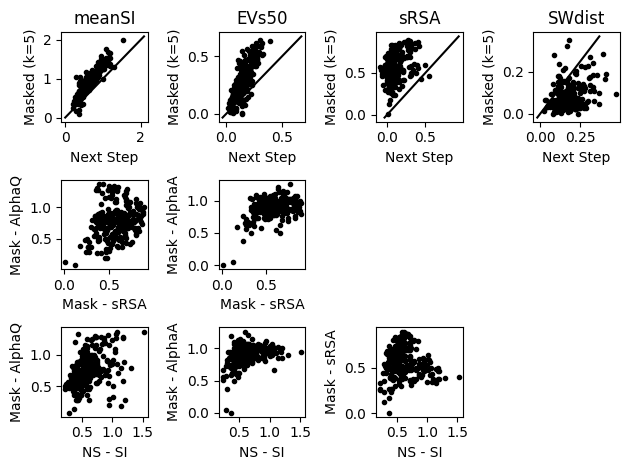

In [19]:
metrics = ['meanSI','EVs50','sRSA','SWdist']
plt.figure()
for midx,metric in enumerate(metrics):
    plt.subplot(3,4,midx+1)
    plt.plot(analysisFrame_NS[metric],analysisFrame_mask[metric],'k.')
    plt.plot(plt.ylim(),plt.ylim(),'k')
    plt.xlabel('Next Step')
    plt.ylabel('Masked (k=5)')
    plt.title(metric)

plt.subplot(3,4,5)
plt.plot(analysisFrame_mask.sRSA,analysisFrame_mask.alphaQ,'k.')
plt.xlabel('Mask - sRSA')
plt.ylabel('Mask - AlphaQ')

plt.subplot(3,4,6)
plt.plot(analysisFrame_mask.sRSA,analysisFrame_mask.alphaA,'k.')
plt.xlabel('Mask - sRSA')
plt.ylabel('Mask - AlphaA')

    
plt.subplot(3,4,9)
plt.plot(analysisFrame_NS.meanSI,analysisFrame_mask.alphaQ,'k.')
plt.xlabel('NS - SI')
plt.ylabel('Mask - AlphaQ')

plt.subplot(3,4,10)
plt.plot(analysisFrame_NS.meanSI,analysisFrame_mask.alphaA,'k.')
plt.xlabel('NS - SI')
plt.ylabel('Mask - AlphaA')

plt.subplot(3,4,11)
plt.plot(analysisFrame_NS.meanSI,analysisFrame_mask.sRSA,'k.')
plt.xlabel('NS - SI')
plt.ylabel('Mask - sRSA')

plt.tight_layout()

saveFig(plt.gcf(),'Hparmcompare'+seeds[0],savefolder,
        filetype='pdf')


plt.show()